In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import lightgbm as lgb
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict

In [4]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
from utilities import bs_calibrate, bs_results, utils

# Data Prepration

In [6]:
df = pd.read_csv("../dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("../dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

In [7]:
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
    'num_leaves': trial.suggest_int('num_leaves', 2, 256),
    'max_depth': trial.suggest_int('max_depth', -1, 50),  # -1 means no limit
    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    'max_bin': trial.suggest_int('max_bin', 10, 500),
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
    'verbose': -1  # Suppress output
}

    lgbm_clf = make_pipeline(preprocessor, lgb.LGBMClassifier(**params))
    cv_roc_auc = cross_val_score(lgbm_clf, X_t, y_t, cv=10, scoring='roc_auc').mean()
    return cv_roc_auc

In [8]:
storage_name = "sqlite:///db.sqlite3"
# sampler = TPESampler(seed=72)
# # Random seeds - 42,50,58,66,72
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="LGBM_one_day_assessment_final04")
# study.optimize(objective, n_trials=1000)

In [9]:
storage_name = "sqlite:///db.sqlite3"
loaded_study = optuna.create_study(study_name="LGBM_one_day_assessment_final03", storage=storage_name, load_if_exists=True)
best_params = loaded_study.best_params

[I 2024-08-03 14:00:00,994] Using an existing study with name 'LGBM_one_day_assessment_final03' instead of creating a new one.


In [10]:
best_params['verbose'] = -1

## Bootstraping and Calibration

In [11]:
# For Gradient Boosting
top_models_lgbm, results_lgbm, calibration_data_lgbm = bs_calibrate.bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, lgb.LGBMClassifier, best_params
)

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

## Saving Data

In [12]:
joblib.dump(top_models_lgbm, '../LightGBM_Models/top_models_lgbm.joblib')
joblib.dump(results_lgbm, '../LightGBM_Models/results.joblib')
joblib.dump(calibration_data_lgbm, '../LightGBM_Models/calibration_data_lgbm.joblib')

['../LightGBM_Models/calibration_data_lgbm.joblib']

## Plotting and calibration curve

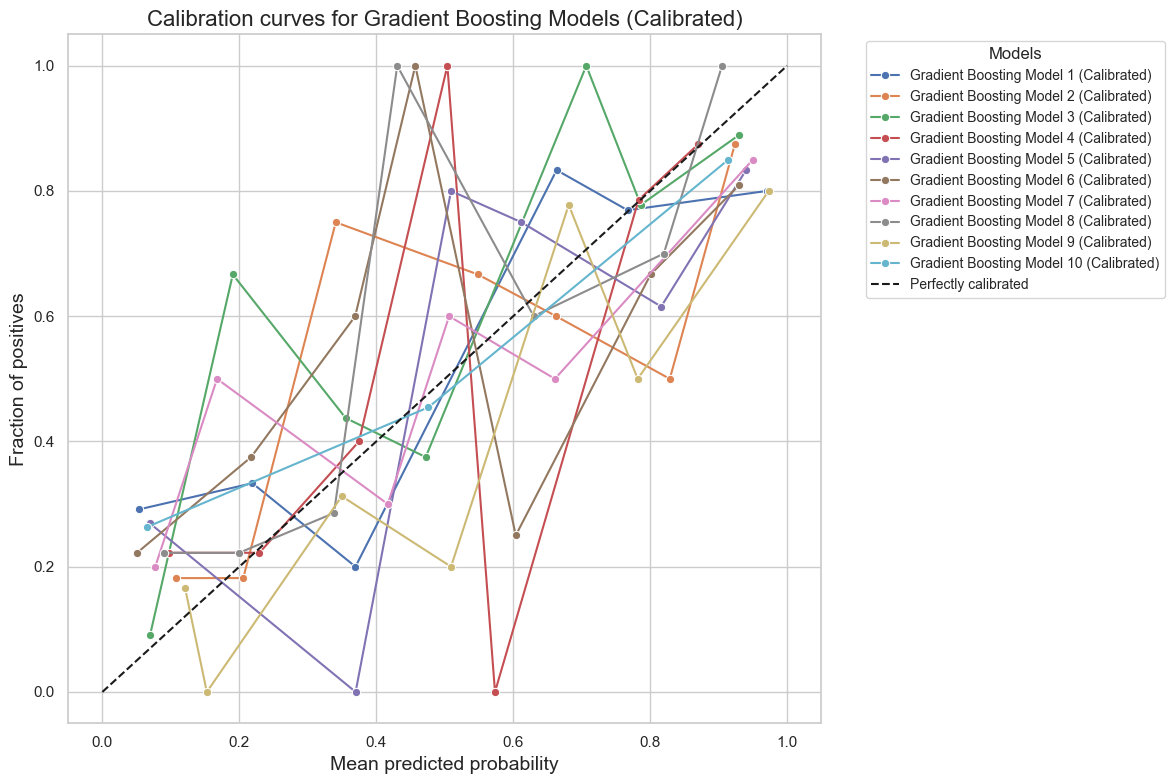

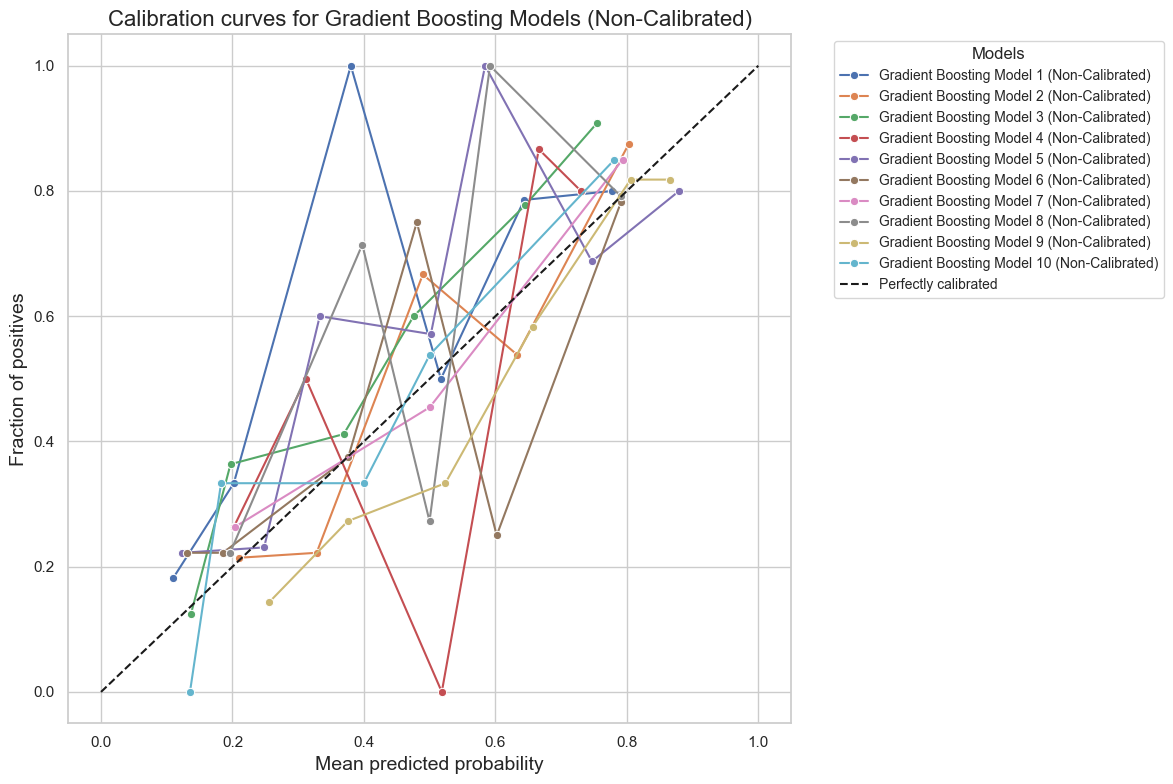

In [13]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('../LightGBM_Models/calibration_data_lgbm.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=False)



## Extract feature importances and save them in a csv file

In [14]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='feature_importances.csv', 
                                                       model_name_prefix='gb', 
                                                       top_models_path='../LightGBM_Models/top_models_lgbm.joblib')

Data saved to - feature_importances.csv


## Plot Feature Importance

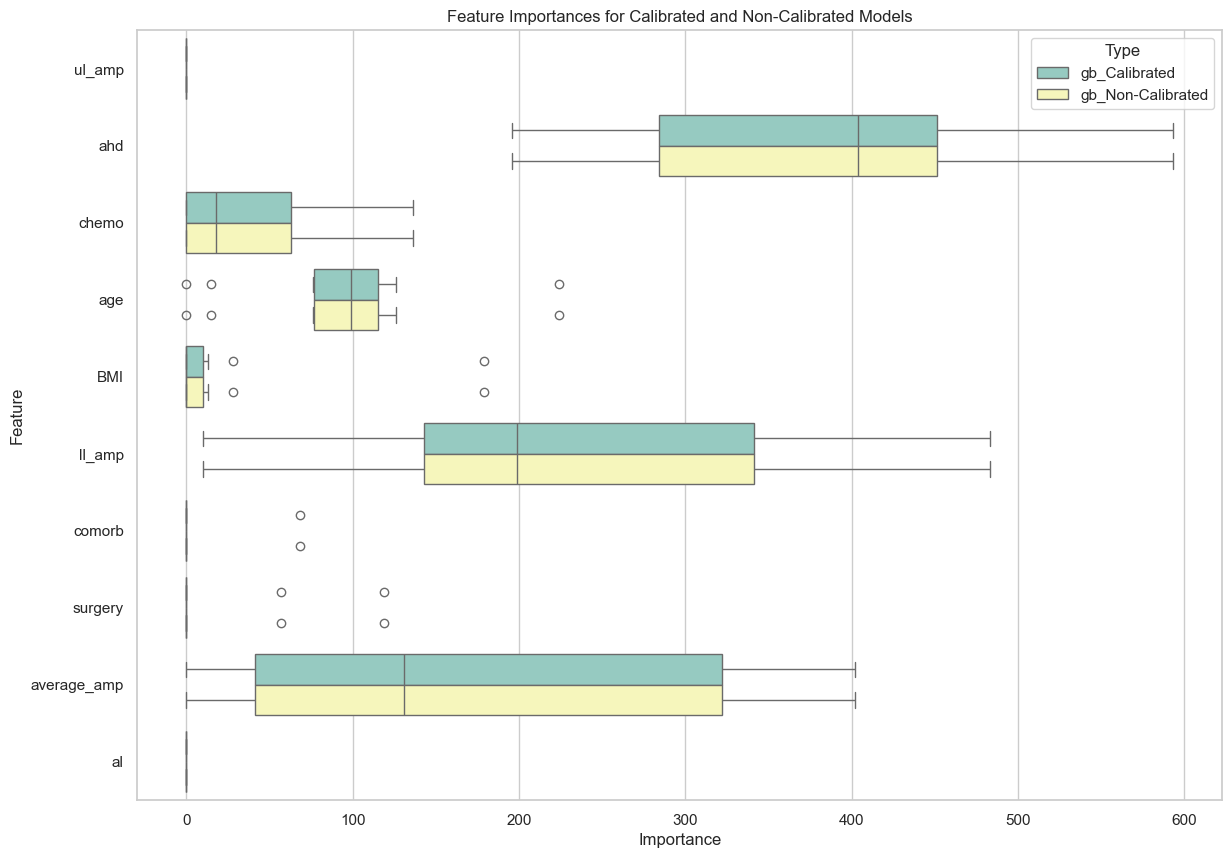

In [15]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for models into a csv file

In [16]:
loaded_results = joblib.load('../LightGBM_Models/results.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.721393   0.744276  0.732437  0.731472  0.733540
std           0.019552   0.052619  0.093233  0.033470  0.027431
min           0.606557   0.620000  0.312500  0.465116  0.634698
max           0.770492   0.909091  0.968750  0.805556  0.798491
95% CI lower  0.683072   0.641144  0.549700  0.665870  0.679774
95% CI upper  0.759714   0.847409  0.915175  0.797074  0.787305

Non-Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.725623   0.765682  0.707125  0.726534  0.747040
std           0.018627   0.057062  0.104969  0.038925  0.023736
min           0.639344   0.645833  0.437500  0.595745  0.651401
max           0.786885   0.941176  0.968750  0.811594  0.796875
95% CI lower  0.689113   0.653841  0.501386  0.650242  0.700518
95% CI upper  0.762133   0.877523  0.912864  0.802826  0.793562


In [17]:
filename='../saved_models/final_results.csv'
model_name = 'LGBM'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

'Data saved to ../saved_models/final_results.csv'

# BOOTSTRAP SAMPLING and TRAINING

In [ ]:
# top_models = []
# fraction_of_positives_calibrated_list = []
# mean_predicted_value_calibrated_list = []
# fraction_of_positives_non_calibrated_list = []
# mean_predicted_value_non_calibrated_list = []
# results = []

# for i in range(1000):
#     X_resampled, y_resampled = resample(X_t, y_t)
#     X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

#     lgbm_pipeline = make_pipeline(preprocessor, lgb.LGBMClassifier(**best_params))
#     lgbm_pipeline.fit(X_train_resampled, y_train_resampled)
#     y_proba_non_calibrated = lgbm_pipeline.predict_proba(X_v)[:, 1]

#     best_lgbm_pipeline = make_pipeline(preprocessor, lgb.LGBMClassifier(**best_params))
#     model = CalibratedClassifierCV(best_lgbm_pipeline, method='sigmoid', cv=10)
#     model.fit(X_train_resampled, y_train_resampled)
#     y_proba_calibrated = model.predict_proba(X_v)[:, 1]

#     fraction_of_positives_non_calibrated, mean_predicted_value_non_calibrated = calibration_curve(y_v, y_proba_non_calibrated, n_bins=6)
#     if len(fraction_of_positives_non_calibrated) == 6:
#         fraction_of_positives_non_calibrated_list.append(fraction_of_positives_non_calibrated)
#         mean_predicted_value_non_calibrated_list.append(mean_predicted_value_non_calibrated)

#     fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_v, y_proba_calibrated, n_bins=6)
#     if len(fraction_of_positives_calibrated) == 6:
#         fraction_of_positives_calibrated_list.append(fraction_of_positives_calibrated)
#         mean_predicted_value_calibrated_list.append(mean_predicted_value_calibrated)

#     fpr, tpr, thresholds = roc_curve(y_v, y_proba_calibrated)
#     roc_auc = auc(fpr, tpr)
#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     y_pred_optimal = (y_proba_calibrated >= optimal_threshold).astype(int)

#     model_info = {
#         'model': model,
#         'fpr': fpr,
#         'tpr': tpr,
#         'thresholds': thresholds,
#         'roc_auc': roc_auc,
#         'optimal_threshold': optimal_threshold,
#         'accuracy': accuracy_score(y_v, y_pred_optimal),
#         'precision': precision_score(y_v, y_pred_optimal),
#         'recall': recall_score(y_v, y_pred_optimal),
#         'f1_score': f1_score(y_v, y_pred_optimal),
#         'confusion_matrix': confusion_matrix(y_v, y_pred_optimal),
#         'classification_report': classification_report(y_v, y_pred_optimal)
#     }

#     model_info_without_model = {key: value for key, value in model_info.items() if key != 'model'}
#     results.append(model_info_without_model)

#     if len(top_models) < 10:
#         top_models.append(model_info)
#     else:
#         min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc'], top_models[x]['recall']))
#         if roc_auc > top_models[min_index]['roc_auc']:
#             top_models[min_index] = model_info

#     if (i + 1) % 25 == 0:
#         print(f"Bootstrap sample no. {i + 1} ------ Finished")

# Plotting the calibration curve

In [ ]:
# # Calculate the mean calibration curve

# mean_fraction_of_positives_calibrated = np.mean(fraction_of_positives_calibrated_list, axis=0)
# mean_mean_predicted_value_calibrated = np.mean(mean_predicted_value_calibrated_list, axis=0)
# mean_fraction_of_positives_non_calibrated = np.mean(fraction_of_positives_non_calibrated_list, axis=0)
# mean_mean_predicted_value_non_calibrated = np.mean(mean_predicted_value_non_calibrated_list, axis=0)

# # Plot the calibration curves
# plt.figure(figsize=[8, 6])
# plt.plot(mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
# plt.plot(mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
# plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
# plt.xlabel("Mean predicted probability")
# plt.ylabel("Fraction of positives")
# plt.title("Calibration curves using Bootstrapping")
# plt.legend()
# plt.show()

In [ ]:
### There is no advantage of model calibration so bootstraping without model calibration (checked both methods, sigmoid and isotonic)

# Bootstraping without calibration

In [ ]:
top_models = []
results = []

for i in range(1000):
    X_resampled, y_resampled = resample(X_t, y_t)
    X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

    lgbm_pipeline = make_pipeline(preprocessor, lgb.LGBMClassifier(**best_params))  # Suppress output
    lgbm_pipeline.fit(X_train_resampled, y_train_resampled)
    y_proba_non_calibrated = lgbm_pipeline.predict_proba(X_v)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_v, y_proba_non_calibrated)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba_non_calibrated >= optimal_threshold).astype(int)

    model_info = {
        'model': lgbm_pipeline,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy_score(y_v, y_pred_optimal),
        'precision': precision_score(y_v, y_pred_optimal),
        'recall': recall_score(y_v, y_pred_optimal),
        'f1_score': f1_score(y_v, y_pred_optimal),
        'confusion_matrix': confusion_matrix(y_v, y_pred_optimal),
        'classification_report': classification_report(y_v, y_pred_optimal)
    }

    model_info_without_model = {key: value for key, value in model_info.items() if key != 'model'}
    results.append(model_info_without_model)

    if len(top_models) < 10:
        top_models.append(model_info)
    else:
        min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc'], top_models[x]['recall']))
        if roc_auc > top_models[min_index]['roc_auc']:
            top_models[min_index] = model_info

    if (i + 1) % 25 == 0:
        print(f"Bootstrap sample no. {i + 1} ------ Finished")

# RESULTS

In [ ]:
# RESULTS
df_results = pd.DataFrame(results)

metric_summary = df_results[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].agg(['mean', 'std', 'min', 'max'])
metric_summary.loc['95% CI lower'] = metric_summary.loc['mean'] - 1.96 * metric_summary.loc['std']
metric_summary.loc['95% CI upper'] = metric_summary.loc['mean'] + 1.96 * metric_summary.loc['std']

print(metric_summary)

# Saving top 10 models

In [ ]:
model_folder_path = '../saved_models/one_day_lgbm_top10'

if os.path.exists(model_folder_path):
    shutil.rmtree(model_folder_path)
os.makedirs(model_folder_path)

for i, m in enumerate(top_models):
    model_path = os.path.join(model_folder_path, f'top_model_{i+1}.joblib')
    joblib.dump(m['model'], model_path)

preprocessor_path = os.path.join(model_folder_path, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)

print(f"All top models have been saved to folder: {model_folder_path}")
print(f"Preprocessor has been saved as {preprocessor_path}")

# Creating Ensemble Model

In [ ]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

joblib_file = '../saved_models/one_day_lgbm_top10/ensemble_classifier_lgbm.joblib'
joblib.dump(ensemble_classifier, joblib_file)

# Load the ensemble classifier from a .joblib file

In [ ]:
ensemble_classifier = joblib.load(joblib_file)
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

# Calibrating the ensemble model

In [ ]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
        self.calibrator = None
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        if self.calibrator:
            probabilities = self.calibrator.transform(probabilities)
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        predictions = (probabilities >= 0.5).astype(int)
        return predictions
    
    def calibrate(self, X, y):
        probabilities = self.predict_proba(X)
        self.calibrator = IsotonicRegression(out_of_bounds='clip')
        self.calibrator.fit(probabilities, y)
        return self

ensemble_models = [(m['model'], m['optimal_threshold']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

# Save the ensemble classifier before calibration
joblib_file = '../saved_models/one_day_lgbm_top10/ensemble_classifier_lgbm.joblib'
joblib.dump(ensemble_classifier, joblib_file)

# Calibrate the ensemble classifier on the prospective internal validation data
ensemble_classifier.calibrate(X_int_val, y_int_val)

# Save the calibrated ensemble classifier
joblib_file_calibrated = '../saved_models/one_day_lgbm_top10/calibrated_ensemble_classifier_lgbm.joblib'
joblib.dump(ensemble_classifier, joblib_file_calibrated)

# Now we can use the calibrated ensemble classifier to make predictions

In [ ]:
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

# Evaluate the ensemble performance on prospective data as needed
print("Calibrated Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Calibrated Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Calibrated Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Calibrated Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Calibrated Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

# Result for publication

In [ ]:
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

In [ ]:
joblib_file = '../saved_models/one_day_lgbm_top10/ensemble_classifier_lgbm.joblib'
ensemble_classifier = joblib.load(joblib_file)

In [ ]:
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))

In [ ]:
results_df = pd.DataFrame({
    'actual_outcome': y_int_val,
    'predicted_probability': y_proba
})

# Save the DataFrame to a CSV file
results_df.to_csv('../saved_models/one_day_lgbm_top10/lgbm_predictions.csv', index=False)